In [0]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import warnings
import json


import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline


warnings.filterwarnings('ignore')


nf_data_path = r'./noFinacialFeatures.csv'
f_data_path = r'./FinacialFeatures.csv'

In [0]:
nf_df = pd.read_csv(nf_data_path)
f_df = pd.read_csv(f_data_path)

In [0]:
df = pd.DataFrame()
df = nf_df.copy()
f_df.drop(['企业总评分'], axis=1, inplace=True)
df = df.merge(f_df, how='left', on='企业编号')

In [0]:
y = df[['企业编号', '企业总评分']]
x = df.drop(['企业总评分'], axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=0)
ytrain_id = ytrain['企业编号']
ytrain = ytrain['企业总评分']
ytest_id = ytest['企业编号']
ytest = ytest['企业总评分']
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

id_train = xtrain['企业编号']
id_test = xtest['企业编号']
xtrain.drop(['企业编号'], axis=1, inplace=True)
xtest.drop(['企业编号'], axis=1, inplace=True)

# Check NaN

In [31]:
print(xtrain.isnull().values.any())
print(ytrain.isnull().values.any())
print(xtest.isnull().values.any())
print(ytest.isnull().values.any())

False
False
False
False


# Normal use

In [0]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [75]:
traindf, testdf = train_test_split(xtrain, test_size = 0.3)
xgb.fit(xtrain,ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.75)

In [0]:
pred = xgb.predict(xtest)

In [77]:
np.sqrt(mse(pred.astype(int), ytest.astype(int)))

3.239849012164243

# Cross Validation

In [0]:
nfolds = 10
folds = KFold(n_splits=nfolds, random_state=3228, shuffle=True)

## xbg.XGBRegressor

In [78]:
feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
mvalid = np.zeros(len(xtrain))
mfull = np.zeros(len(xtest))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
    print('----')
    print("fold n°{}".format(fold_))
    
    x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
    x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]

    
#     model = XGBRegressor(n_estimators=100, 
#                          learning_rate=0.005, 
#                          gamma=0, 
#                          subsample=0.75,
#                          colsample_bytree=1, 
#                          max_depth=7,
#                          silent=False,
#                          n_jobs=4)
    model = XGBRegressor()
    model.fit(x0, y0)
    mvalid[val_idx] = model.predict(x1)
    feature_importance_df[:, fold_] = model.feature_importances_
    mfull += model.predict(xtest) / folds.n_splits



----
fold n°0
----
fold n°1
----
fold n°2
----
fold n°3
----
fold n°4
----
fold n°5
----
fold n°6
----
fold n°7
----
fold n°8
----
fold n°9


In [79]:
np.sqrt(mse(mfull.astype(int), ytest.astype(int)))

3.1505040351784466

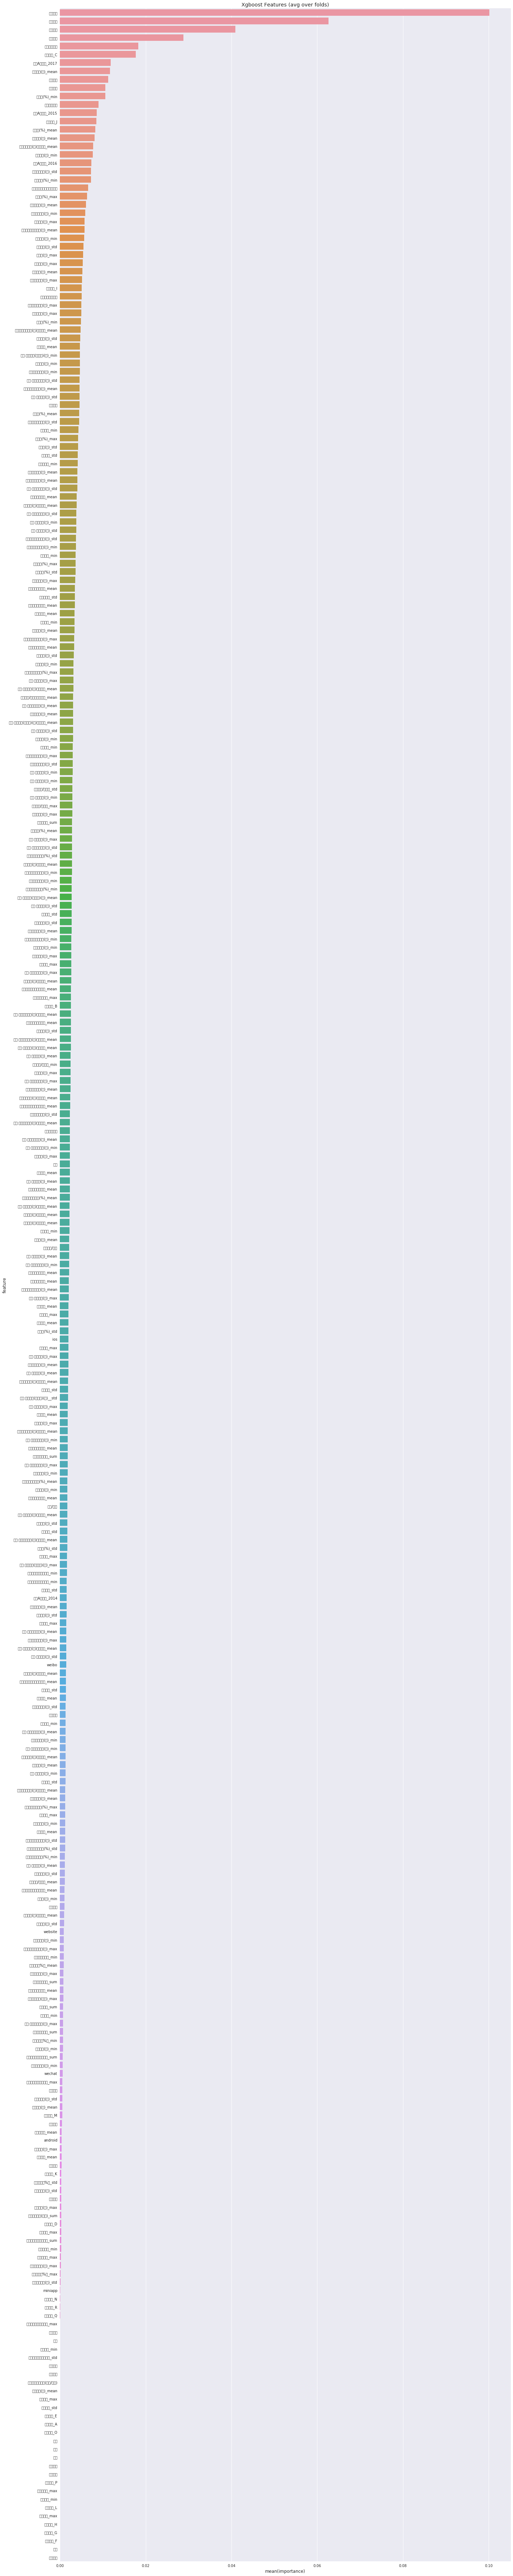

In [81]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain.columns
ximp['importance'] = feature_importance_df.mean(axis=1)

plt.figure(figsize=(20, 100))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                  ascending=False))
plt.title('Xgboost Features (avg over folds)')
plt.tight_layout()

## xgb.Train (Useless)

In [0]:
# params = {'eta': 0.02, 
#               'max_depth': 4, 
#               'subsample': 0.9, 
#               'colsample_bytree': 0.9,
#               'objective': 'reg:logistic',
#               'eval_metric': 'rmse', 
#               'seed': 99, 
#               'silent': True}


params = {
#     'objective': 'reg:squarederror',  # 任务
    'num_class': 10,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 4,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 0,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.007,                  # 如同学习率
    'seed': 1000,
    'nthread': 4,                  # cpu 线程数
    "booster" : "gbtree"
}

In [69]:
feature_importance_df_trd = np.zeros((xtrain.shape[1], nfolds))
mvalid_trd = np.zeros(len(xtrain))
mfull_trd = np.zeros(len(xtest))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
    print('----')
    print("fold n°{}".format(fold_))
    
    x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
    x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]
    
    trn_data = xgb.DMatrix(x0, label=y0)
    val_data = xgb.DMatrix(x1, label=y1)
    d_test = xgb.DMatrix(xtest)
    

#     d_train = xgb.DMatrix(train_X, label = train_y)
#     d_valid = xgb.DMatrix(valid_X, label = valid_y)
#     d_test = xgb.DMatrix(xtest)

    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    
    mdl = xgb.train(params, trn_data, 1600, watchlist, early_stopping_rounds=70, verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    
    mvalid_trd[val_idx] = model.predict(x1)
    feature_importance_df_trd[:, fold_] = model.feature_importances_
    mfull_trd += p_test / folds.n_splits


----
fold n°0


XGBoostError: ignored